In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [129]:
vcf = pd.read_csv('/Users/clairez/Desktop/BNFO285_Projects/Data/original/TCGA.HNSC.mutations.txt', sep='\t', header=0)
vcf

,patient_id,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,...,SIFT,PolyPhen,DOMAINS,IMPACT,VARIANT_CLASS,FILTER,COSMIC,CALLERS,CONTEXT,NCALLERS
0,TCGA-4P-AA8J,PIP4K2A,0,.,GRCh37,10,22830863,22830863,+,Silent,...,.,.,"Low_complexity_(Seg):seg,PROSITE_profiles:PS51...",LOW,SNV,common_in_exac,NONE,MUTECT|VARSCANS,CTCTCGCCCTC,2
1,TCGA-4P-AA8J,NRP1,0,.,GRCh37,10,33495214,33495214,+,Intron,...,.,.,.,MODIFIER,SNV,PASS,NONE,MUTECT|RADIA|SOMATICSNIPER|MUSE|VARSCANS,CATCTCTTCTT,5
2,TCGA-4P-AA8J,PFKFB3,0,.,GRCh37,10,6257188,6257188,+,Silent,...,.,.,"Superfamily_domains:SSF52540,PIRSF_domain:PIRS...",LOW,SNV,PASS,NONE,RADIA|MUTECT|MUSE|VARSCANS,GTGTTCAACGT,4
3,TCGA-4P-AA8J,VCL,0,.,GRCh37,10,75849918,75849918,+,Silent,...,.,.,"hmmpanther:PTHR18914:SF22,hmmpanther:PTHR18914...",LOW,SNV,PASS,BUFFER|p.A440D|c.1319C>A|3,RADIA|MUTECT|MUSE|VARSCANS,GAAATATCTGC,4
4,TCGA-4P-AA8J,WAPAL,0,.,GRCh37,10,88260246,88260246,+,Missense_Mutation,...,tolerated_low_confidence(0.77),benign(0),"hmmpanther:PTHR22100:SF13,hmmpanther:PTHR22100",MODERATE,SNV,PASS,NONE,MUTECT|MUSE|VARSCANS,TAAAATACAGT,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124845,TCGA-WA-A7H4,TSNARE1,0,.,GRCh37,8,143381872,143381872,+,Missense_Mutation,...,tolerated(0.07),possibly_damaging(0.847),"PROSITE_profiles:PS50192,hmmpanther:PTHR19957:...",MODERATE,SNV,PASS,NONE,MUTECT|MUSE|VARSCANS,CCTCCCGCAGC,3
124846,TCGA-WA-A7H4,TOX,0,.,GRCh37,8,59728263,59728263,+,Silent,...,.,.,"hmmpanther:PTHR13711,hmmpanther:PTHR13711:SF15...",LOW,SNV,PASS,NONE,RADIA|MUTECT|MUSE|VARSCANS,TTCACGTCAAC,4
124847,TCGA-WA-A7H4,RDH10,0,.,GRCh37,8,74235183,74235183,+,Missense_Mutation,...,tolerated(0.2),possibly_damaging(0.504),"hmmpanther:PTHR24316:SF309,hmmpanther:PTHR2431...",MODERATE,SNV,PASS,NONE,MUTECT|MUSE,GTATCGGTTCC,2
124848,TCGA-WA-A7H4,FAM154A,0,.,GRCh37,9,18927993,18927993,+,3'UTR,...,.,.,.,MODIFIER,SNV,PASS,NONE,MUTECT|MUSE,ATAATTCTCAG,2


In [181]:
variant_classifications = {
    "Silent", "Missense_Mutation", "Nonsense_Mutation"
}

filtered_vcf = vcf[vcf['Variant_Classification'].isin(variant_classifications)]
# filtered_vcf.to_csv('~/Desktop/filtered_vcf.csv', index=False)

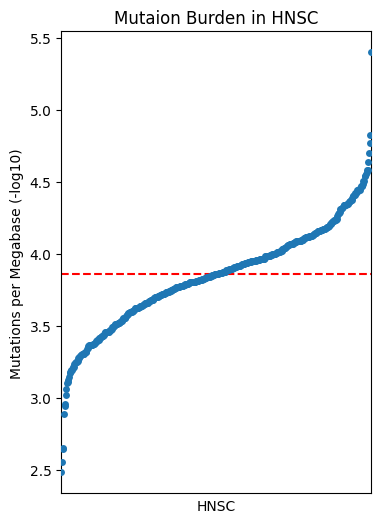

In [182]:
mutation_counts = filtered_vcf.groupby('patient_id')['Variant_Classification'].count()
mutation_burden =  mutation_counts / 1e6
medians = mutation_burden.median()

df = pd.DataFrame(columns=['patient_id', 'mutation_burden'])
df['patient_id'] = mutation_counts.index
df['mutation_burden'] = -np.log10(mutation_burden.values)
df = df.sort_values(by='mutation_burden', ascending=True)

plt.figure(figsize=(4, 6))

sns.stripplot(x='patient_id', y='mutation_burden', data=df, jitter=True, dodge=True)
plt.axhline(y=-np.log10(medians), color='r', linestyle='--', label='Median Mutation Burden')

plt.title('Mutaion Burden in HNSC')
plt.xlabel('HNSC')
plt.ylabel('Mutations per Megabase (-log10)')
plt.xticks([])
plt.show()

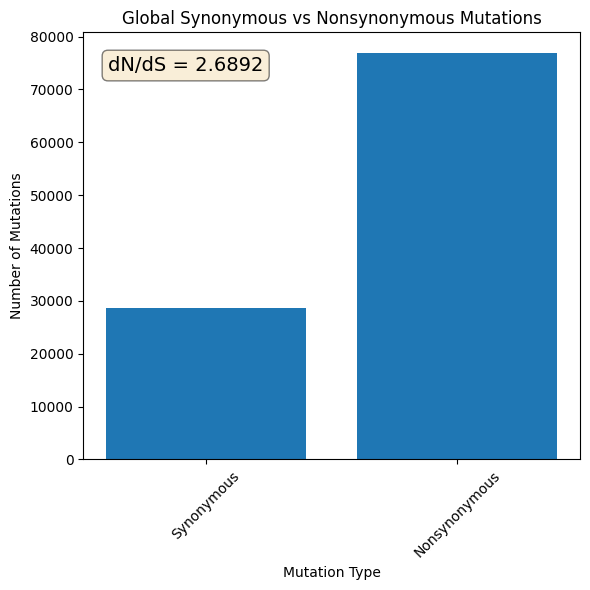

In [183]:
global_n_synonymous =  len(filtered_vcf[filtered_vcf['Variant_Classification'] == 'Silent'])
global_n_nonsynonymous =  len(filtered_vcf[filtered_vcf['Variant_Classification'] != 'Silent'])
global_dnds = global_n_nonsynonymous/global_n_synonymous

plt.figure(figsize=(6, 6))
plt.bar(['Synonymous', 'Nonsynonymous'], [global_n_synonymous, global_n_nonsynonymous])
plt.title('Global Synonymous vs Nonsynonymous Mutations')
plt.xlabel('Mutation Type')
plt.ylabel('Number of Mutations')
plt.xticks(rotation=45)
plt.tight_layout()

ax = plt.gca()
ax.text(0.05, 0.9, f"dN/dS = {global_dnds:.4f}",
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()

In [191]:
genes = filtered_vcf['Hugo_Symbol'].unique()
dnds_table = pd.DataFrame(columns=['Gene', 'count_syn', 'count_nonsym', 'dN/dS'])
for gene in genes:
    n_synonymous = len(filtered_vcf[(filtered_vcf['Hugo_Symbol'] == gene) & (filtered_vcf['Variant_Classification'] == 'Silent')])
    n_nonsynonymous = len(filtered_vcf[(filtered_vcf['Hugo_Symbol'] == gene) & (filtered_vcf['Variant_Classification'] != 'Silent')])
    dnds = n_nonsynonymous / n_synonymous if n_synonymous > 0 else np.nan
    new_row = pd.DataFrame({'Gene': [gene], 'count_syn': [n_synonymous], 'count_nonsym': [n_nonsynonymous], 'dN/dS': [dnds]})
    dnds_table = pd.concat([dnds_table, new_row], ignore_index=True)
dnds_table = dnds_table.dropna()
dnds_table = dnds_table.sort_values(by='dN/dS', ascending=False)

/var/folders/_k/b8vsv8097ss3sxnsdwkx1y_80000gn/T/ipykernel_71239/795218064.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dnds_table = pd.concat([dnds_table, new_row], ignore_index=True)


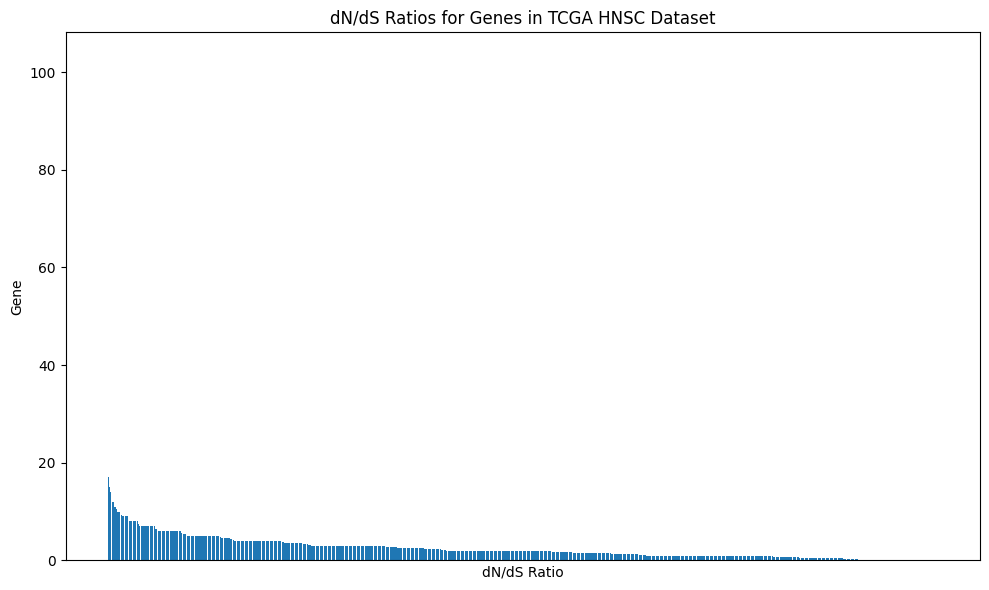

In [193]:
plt.figure(figsize=(10, 6))
plt.bar(dnds_table['Gene'], dnds_table['dN/dS'])
plt.xlabel('dN/dS Ratio')
plt.xticks([])
plt.ylabel('Gene')
plt.title('dN/dS Ratios for Genes in TCGA HNSC Dataset')
plt.tight_layout()
plt.show()

In [192]:
print(dnds_table.head(25))


         Gene count_syn count_nonsym       dN/dS
954    PIK3CA         1          103  103.000000
2364   CDKN2A         1           89   89.000000
2288    CASP8         1           54   54.000000
819     HERC1         1           30   30.000000
5741   JMJD1C         1           24   24.000000
2467  ANKRD17         1           23   23.000000
45       TP53        17          359   21.117647
2178     NSD1         3           61   20.333333
2124    SMAD4         1           19   19.000000
4745    ASH1L         1           19   19.000000
9663    NCOR1         1           19   19.000000
3801     CHD8         1           19   19.000000
4788  ADAMTS9         1           18   18.000000
2200     EYA1         1           18   18.000000
5311    RASA1         1           17   17.000000
6865    MYOM1         1           17   17.000000
4927     DLG2         1           17   17.000000
780      LRP6         1           17   17.000000
2946    CARD6         1           17   17.000000
4506    HLA-B       

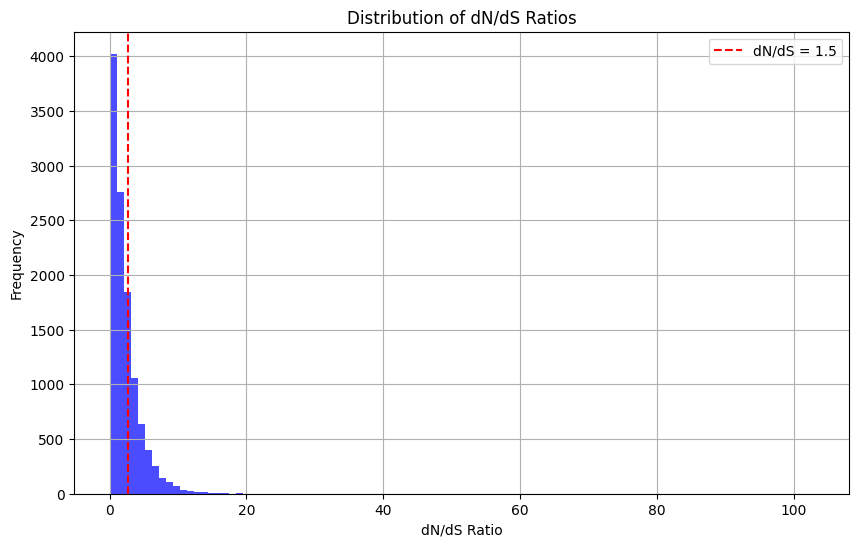

In [187]:
plt.figure(figsize=(10, 6))
plt.hist(dnds_table['dN/dS'], bins=100, color='blue', alpha=0.7)
plt.xlabel('dN/dS Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of dN/dS Ratios')
plt.axvline(x=global_dnds, color='red', linestyle='--', label='dN/dS = 1.5')
plt.legend()
plt.grid()
plt.show()